<a href="https://colab.research.google.com/github/purvikansara/Machine-Learning/blob/master/Digit_MNIST(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
# Layers for CNN
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
# Convert numerical outcome to categorical class
from tensorflow.keras.utils import to_categorical
#Hand written numbers
from tensorflow.keras.datasets import mnist
from sklearn.metrics import accuracy_score

In [5]:
df_train = pd.read_csv('/MNIST_train.csv')

In [6]:
df_test = pd.read_csv('/MNIST_test.csv')

In [7]:
df_train.tail()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41999,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# make the feature and target selection in X and y and scale between 0 and 1 by dividing by 255
X = df_train.drop(columns = "label")/255
y = df_train.label

In [9]:
X_test =df_test/255

In [11]:
# Train test split for validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=123)

In [12]:
X_train.shape

(33600, 784)

In [13]:
y_train.unique()

array([2, 9, 1, 5, 3, 8, 0, 7, 4, 6])

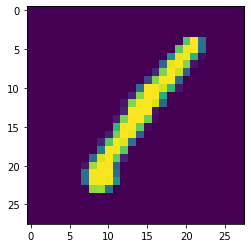

In [14]:
# Lets look at the data/digits we have


plt.imshow(np.array(X_train.loc[0, :]).reshape(28, 28));

In [15]:
# Reshape data
X_train = np.array(X_train).reshape(X_train.shape[0], 28, 28, 1)
X_val = np.array(X_val).reshape(X_val.shape[0], 28, 28, 1)

In [16]:
y_train.shape

(33600,)

In [17]:
# Step 1: Define our network structure
# Save the input shape
input_shape = X_train.shape[1:4]
input_shape

(28, 28, 1)

In [18]:
X_val.shape

(8400, 28, 28, 1)

In [19]:
# convert target to categorical
y_train = to_categorical(y_train, num_classes = 10)
y_val = to_categorical(y_val, num_classes = 10)

In [20]:
print(X_val.shape)
y_val.shape

(8400, 28, 28, 1)


(8400, 10)

In [21]:
# Sequential model
model = Sequential()
# Convolutional layer
model.add(Conv2D(filters = 16, # How many filters you want to use
                 kernel_size = 3, # size of each filter
                 input_shape = input_shape)) # What is the shape of your input features (we defined this above)
# Pooling layer
model.add(MaxPooling2D(pool_size = 2)) # Size of pooling
# Flattening layer
model.add(Flatten())
# Output layer
model.add(Dense(10, # How many output possibilities we have
                activation = 'softmax')) # What activation function are you using?

# Step 2: Compile
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])


# Step 3: Fit our model
history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val), 
                    epochs=20)

Epoch 1/20
1050/1050 [==============================] - 14s 13ms/step - loss: 0.3717 - acc: 0.8957 - val_loss: 0.2410 - val_acc: 0.9311
Epoch 2/20
1050/1050 [==============================] - 13s 12ms/step - loss: 0.2008 - acc: 0.9420 - val_loss: 0.1644 - val_acc: 0.9538
Epoch 3/20
1050/1050 [==============================] - 13s 13ms/step - loss: 0.1407 - acc: 0.9605 - val_loss: 0.1294 - val_acc: 0.9636
Epoch 4/20
1050/1050 [==============================] - 13s 12ms/step - loss: 0.1099 - acc: 0.9693 - val_loss: 0.1123 - val_acc: 0.9667
Epoch 5/20
1050/1050 [==============================] - 13s 12ms/step - loss: 0.0890 - acc: 0.9739 - val_loss: 0.1088 - val_acc: 0.9677
Epoch 6/20
1050/1050 [==============================] - 13s 12ms/step - loss: 0.0775 - acc: 0.9771 - val_loss: 0.0901 - val_acc: 0.9739
Epoch 7/20
1050/1050 [==============================] - 13s 12ms/step - loss: 0.0667 - acc: 0.9803 - val_loss: 0.0919 - val_acc: 0.9726
Epoch 8/20
1050/1050 [==========================

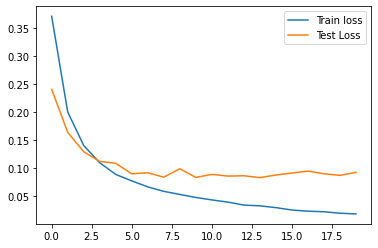

In [22]:
# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

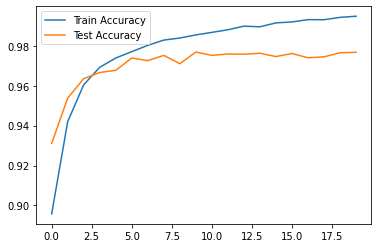

In [23]:
# Visualize the accuracy
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Test Accuracy')
plt.legend();

In [24]:
# get predictions for testing data
X_test = np.array(X_test).reshape(X_test.shape[0], 28, 28, 1)

# could use .predict_classes, but it is deprecated so I will use .predict with argmax
# preds = model.predict_classes(X_test)
preds = np.argmax(model.predict(X_test), axis=-1)

In [25]:
df_test['Label'] =preds

In [26]:
df_test.index = np.arange(1, len(df_test) + 1)

In [29]:

submission = pd.DataFrame({'ImageId':  df_test.index, 'Label': df_test['Label']})


submission.to_csv('/content/drive/MyDrive/KAGGLE/submission.csv', index= False)

In [30]:
# Save model
model.save('mnist_classification.h5')

In [32]:
from flask import Flask, render_template, request, jsonify
import numpy as np
from tensorflow import keras
import cv2
import base64

# Initialize flask app
app = Flask(__name__)

# Load prebuilt model
model = keras.models.load_model('mnist_classification.h5')

# Handle GET request
@app.route('/', methods=['GET'])
def drawing():
    return render_template('drawing.html')

# Handle POST request
@app.route('/', methods=['POST'])
def canvas():
    # Recieve base64 data from the user form
    canvasdata = request.form['canvasimg']
    encoded_data = request.form['canvasimg'].split(',')[1]

    # Decode base64 image to python array
    nparr = np.fromstring(base64.b64decode(encoded_data), np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Convert 3 channel image (RGB) to 1 channel image (GRAY)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize to (28, 28)
    gray_image = cv2.resize(gray_image, (28, 28), interpolation=cv2.INTER_LINEAR)

    # Expand to numpy array dimenstion to (1, 28, 28)
    img = np.expand_dims(gray_image, axis=0)

    try:
        prediction = np.argmax(model.predict(img))
        print(f"Prediction Result : {str(prediction)}")
        return render_template('drawing.html', response=str(prediction), canvasdata=canvasdata, success=True)
    except Exception as e:
        return render_template('drawing.html', response=str(e), canvasdata=canvasdata)